# Bounds on the number of samples of size $k$ from a population of size $n$ for various PRNGs and sampling algorithms

This notebook uses entropy-based bounds to find upper bounds on the number of samples that can be generated using a variety of algorithms for generating pseudo-random numbers (PRNs) and for turning sequences of PRNs into samples.

+ a hypothetical sampling algorithm that uses an optimal coding of samples to turn strings of $\log_2{n \choose k}$ bits into samples of size $k$
+ a common algorithm that involves assigning a PRN to each of the $n$ elements, then taking those elements assigned the smallest $k$ numbers to be the sample
+ algorithm R, a streamable algorithm that also uses at least one PRN per element of the population, but avoids the sort.
+ algorithm S of Knuth, another reservoir method
+ algorithm Random-Sample on p. 130 of [Cormen et al. (2009)](https://mitpress.mit.edu/books/introduction-algorithms)

PRNGs considered include [linear congruential generators](https://en.wikipedia.org/wiki/Linear_congruential_generator) (LCGs, including [RANDU](https://en.wikipedia.org/wiki/RANDU)), and the [Mersenne Twister](https://en.wikipedia.org/wiki/Mersenne_Twister). The behavior of the [middle square method](https://en.wikipedia.org/wiki/Middle-square_method) is worse. 
There is some discussion of using cryptographic hash functions to generate PRNs.

[Kellie Ottoboni](http://www.stat.berkeley.edu/~kellieotto/), [Ronald L. Rivest](http://people.csail.mit.edu/rivest/) and [Philip B. Stark](www.stat.berkeley.edu/~stark)



## References

1. Cormen, T.H., C.E. Leiserson, R.L. Rivest and C. Stein, 2009. _Introduction to Algorithms, 3rd edition_, MIT Press.
1. Fishman, G.S., and L.R. Moore, 1981. In Search of Correlation in Multiplicative Congruential Generators with Modulus 2\*\*31-1, _Computer Science and Statistics: Proceedings of the 13 Symposium on the Interface_, William F. Eddy, ed., Springer Verlag, New York.
1. Knuth, D., 1997 _The Art of Computer Programming, V.II: Seminumerical methods_, 3rd edition, Addison-Wesley, Boston.
1. L'Ecuyer, P. and R. Simard, 2007. TestU01: A C Library for Empirical Testing of Random Number Generators, _ACM Trans. Math. Softw._, _33_, http://doi.acm.org/10.1145/1268776.1268777
1. Marsaglia, G., 1968. Random Numbers Fall Mainly in the Planes, _PNAS_, _61_, 25&ndash;28.
1. Marsaglia, G., 2003. Xorshift RNGs. _Journal of Statistical Software_, _8_, 1&ndash;6.
1. Matsumoto, M., and T. Nishimura, 1998. 8). Mersenne twister: a 623-dimensionally equidistributed uniform pseudo-random number generator, _ACM Transactions on Modeling and Computer Simulation_, _8_, 3&ndash;30. doi:10.1145/272991.272995
1. NIST Computer Security Division, _Random Number Generation_ http://csrc.nist.gov/groups/ST/toolkit/rng/
1. http://www.pcg-random.org/
1. Shannon, C.E., 1948. A Mathematical Theory of Communication, _Bell System Technical Journal, 27_, 379&ndash;423, 623&ndash;656. 
1. Vitter, J.S., 1985. Random Sampling with a Reservoir, _ACM Transactions on Mathematical Software, 11_, 37&ndash;57.
1. Wikipedia articles, including https://en.wikipedia.org/wiki/Mersenne_Twister, https://en.wikipedia.org/wiki/Linear_congruential_generator, https://en.wikipedia.org/wiki/Comparison_of_hardware_random_number_generators, https://en.wikipedia.org/wiki/Pseudorandom_number_generator, https://en.wikipedia.org/wiki/List_of_random_number_generators 

In [3]:
%matplotlib inline
from __future__ import division
import math
import numpy as np
import scipy as sp
from scipy.misc import comb, factorial
from scipy.optimize import brentq
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Pseudo-random number generators (PRNGs)

Most computers lack the hardware needed to generate truly random numbers. (But see, e.g., https://en.wikipedia.org/wiki/Comparison_of_hardware_random_number_generators)

Instead, they use algorithms called PRNGs to generate deterministic sequences from an initial "seed," which generally can be set by the user, for instance to an externally generated random value.

Depending on the quality of the PRNG, the sequences behave more or less like sequences of random numbers.

Each time a number is generated, the PRNG's "state" changes.

Must consider fitness for use of PRNGs. What's "good enough?"

Different requirements for statistics with small data, simulations, statistics with big data, and cryptography.

## Properties of PRNGs

+ number of states
    - dimension of state space in bits
    
+ period
    - maximum over initial states of the number of states visited before repeating
    - period &le; number of states
    - if state has $s$ bits, period $\le 2^s$
    - for some PRNGs, period is much less than number of states
    - for some seeds for some PRNGs, number of states visited much less than period
    
+ $k$-distribution
    - suppose $\{X_i\}$ is sequence of $P$ $w$-bit integers
    - define $t_v(X_i)$ to be the first $v$ bits of $X_i$
    - $\{X_i\}$ is $k$-distributed to $v$-bit accuracy if each of the $2^{kv}-1$ possible nonzero $kv$-bit vectors occurs equally often among the $P$ $kv$-bit vectors
$$ (t_v(X_i),\,t_v(X_{i+1}), \ldots ,t_v(X_{i+k-1}))\quad (0\le i<P),$$
and the zero vector occurs once less often.

+ sensitivity to initial state; burn-in
    - many PRNGs don't do well if the seed has too many zeros
    - some require many iterations before output behaves well
    - for some seeds, some PRNGs repeat very quickly

## Some PRNGs

### Middle Square

Dates to Franciscan friar ca. 1240; reinvented by von Neumann, ca. 1949.

Take $n$-digit number, square it, use middle $n$ digits as the "random" and the new seed.

E.g., for $n=4$, take $X_0 = 1234$.

$1234^2 = 1522756$, so $X_1 = 2275$.

$2275^2 = 5175625$, so $X_2 = 7562$.

+ $10^n$ possible states, but not all attainable from a given seed
+ period at most $8^n$, but can be very short. E.g., for $n=4$,
    - 0000, 0100, 2500, 3792, & 7600 repeat forever
    - 0540 &rightarrow; 2916 &rightarrow; 5030 &rightarrow; 3009 &rightarrow; 0540


## Linear Congruential Generators (LCGs)

$$ X_{n+1} = (aX_n +c)\mod m.$$

LCG period is at most $m$.

### Hull-Dobell Theorem: the period of an LCG is $m$ for all seeds $X_0$ iff

+ $m$ and $c$ are relatively prime
+ $a-1$  is divisible by all prime factors of $m$
+ $a-1$  is divisible by 4 if $m$ is divisible by 4


## RANDU

RANDU is a particularly bad [linear congruential generator](https://en.wikipedia.org/wiki/Linear_congruential_generator) promulgated in the 1960s and widely copied.

RANDU is given by the recursion

$$ X_{j+1} = 65539 X_j\mod 2^{31}.$$

It has a short period ($2^{29}$), all its outputs are odd integers. It fails the spectral test.

Triples of values from RANDU fall on 15 planes in 3-dimensional space, as shown below.

In [8]:
# RANDU constants
A = 0
M = 2**31
B = 65539

randu_period = 2**29
randu_word_length = 32

def nextRand(x):
    return (A + B * x) % M

In [9]:
# generate triples using RANDU
x = 1234567890  # seed
reps = 100000
xs = np.ndarray(shape = (3,reps))
for i in range(reps):
    x = nextRand(x)
    xs[0][i] = x
    x = nextRand(x)
    xs[1][i] = x
    x = nextRand(x)
    xs[2][i] = x

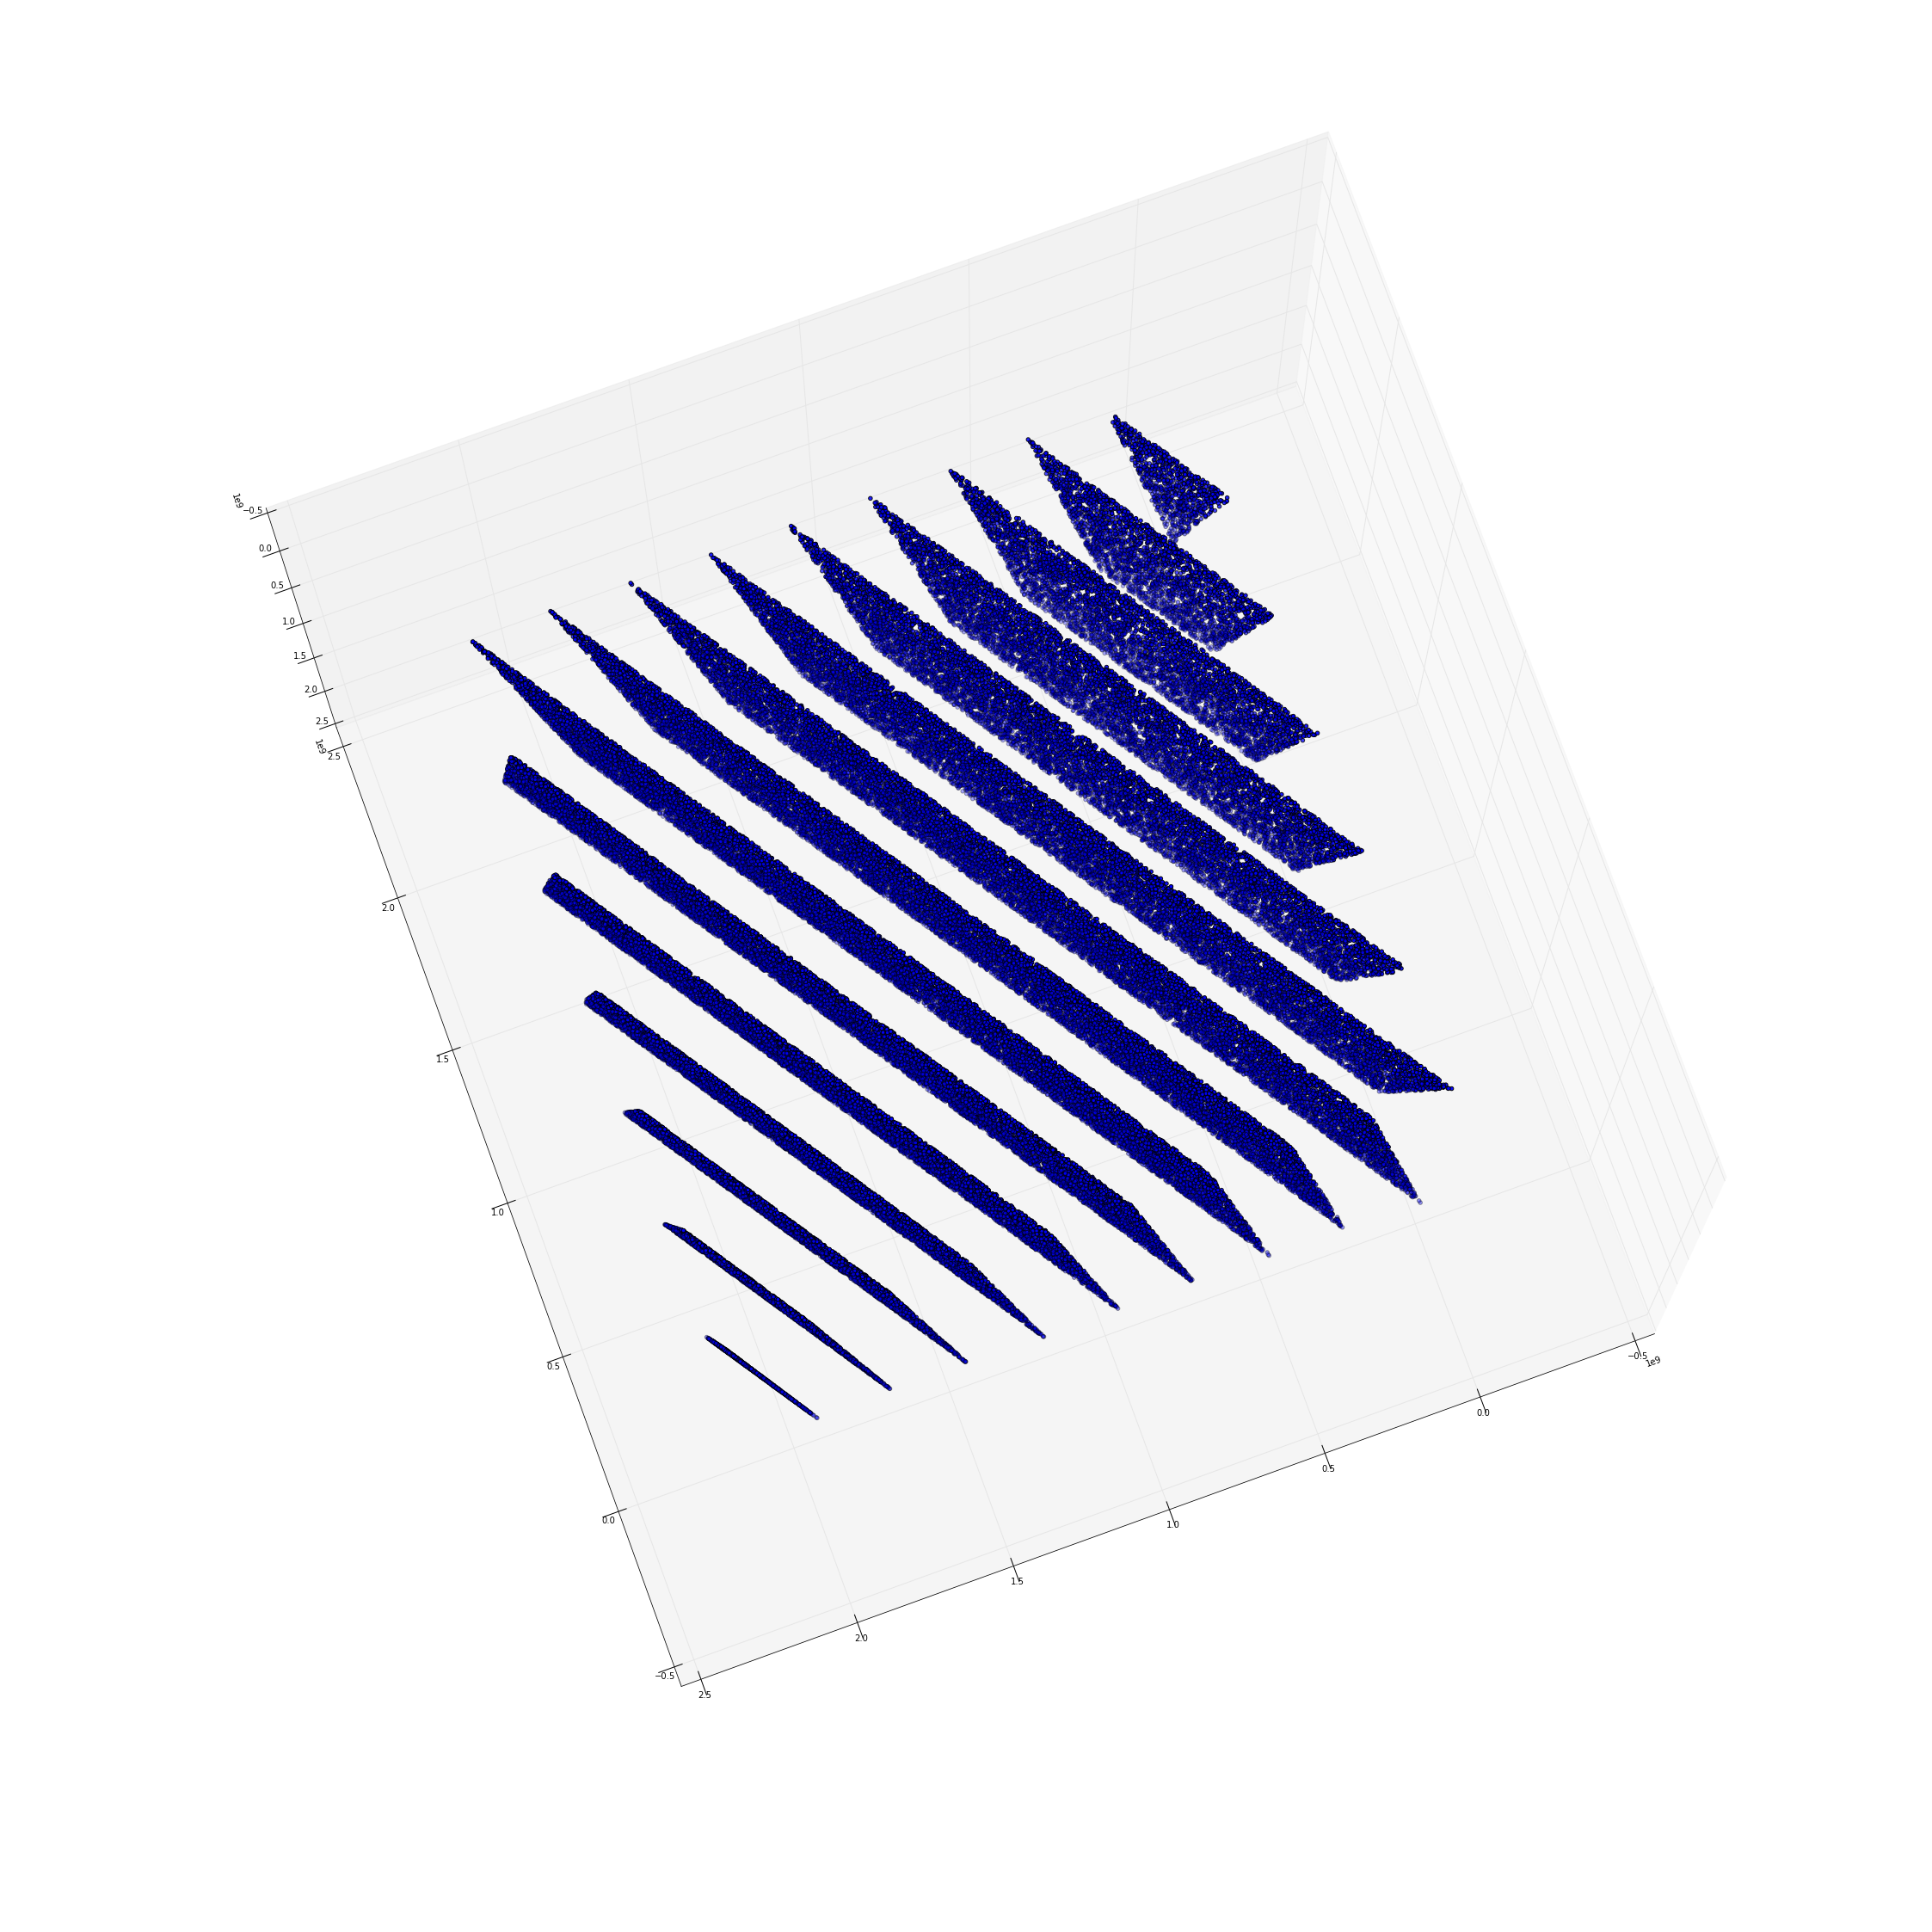

In [77]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs[0],xs[1], xs[2])

plt.rcParams['figure.figsize'] = (40.0, 40.0) 

ax.view_init(-100,110)

plt.show()

### Mersenne Twister (MT)  Matsumoto & Nishimura (1997)

+ example of "twisted generalized feedback shift register"
+ Period $2^{19937}-1$, a Mersenne Prime
+ $k$-distributed to 32-bit accuracy for all $k \in \{1, \ldots, 623\}$. 
+ Passes DIEHARD and most of TestU01 
+ Standard in many packages:
    - GNU Octave, Maple, MATLAB, Mathematica, Python, R, Stata
    - Apache, CMU Common Lisp, Embeddable Common Lisp, Free Pascal, GLib, PHP, GAUSS, IDL, Julia, Ruby, SageMath, Steel Bank Common Lisp, Scilab, Stata, GNU Scientific Library, GNU Multiple Precision Arithmetic Library, Microsoft Visual C++, C++ (v11 and up).
    - SPSS and SAS offer MT 
+ generally considered adequate for statistics
+ Usual implementation has 623-dimensional state space, but TinyMT uses only 127 bits
+ Seeding complicated, since state is an array
+ can take a while to "burn in," especially for seeds with many zeros
+ output for close seed states can be close
+ 2002 update improves seeding

In [ ]:
# Python implementation of MT19937 from Wikipedia 
# https://en.wikipedia.org/wiki/Mersenne_Twister#Python_implementation

def _int32(x):
    # Get the 32 least significant bits.
    return int(0xFFFFFFFF & x)

class MT19937:

    def __init__(self, seed):
        # Initialize the index to 0
        self.index = 624
        self.mt = [0] * 624
        self.mt[0] = seed  # Initialize the initial state to the seed
        for i in range(1, 624):
            self.mt[i] = _int32(
                1812433253 * (self.mt[i - 1] ^ self.mt[i - 1] >> 30) + i)

    def extract_number(self):
        if self.index >= 624:
            self.twist()

        y = self.mt[self.index]

        # Right shift by 11 bits
        y = y ^ y >> 11
        # Shift y left by 7 and take the bitwise and of 2636928640
        y = y ^ y << 7 & 2636928640
        # Shift y left by 15 and take the bitwise and of y and 4022730752
        y = y ^ y << 15 & 4022730752
        # Right shift by 18 bits
        y = y ^ y >> 18

        self.index = self.index + 1

        return _int32(y)

    def twist(self):
        for i in range(624):
            # Get the most significant bit and add it to the less significant
            # bits of the next number
            y = _int32((self.mt[i] & 0x80000000) +
                       (self.mt[(i + 1) % 624] & 0x7fffffff))
            self.mt[i] = self.mt[(i + 397) % 624] ^ y >> 1

            if y % 2 != 0:
                self.mt[i] = self.mt[i] ^ 0x9908b0df
        self.index = 0

### xorshift family

Originated by Marsaglia, 2003.

Vigna, S., 2014. Further scramblings of Marsaglia's xorshift generators. https://arxiv.org/abs/1404.0390

128-bit xorshift+  Implemented in Python package randomstate https://pypi.python.org/pypi/randomstate/1.10.1

    uint64_t s[2];

    uint64_t xorshift128plus(void) {
	    uint64_t x = s[0];
	    uint64_t const y = s[1];
	    s[0] = y;
	    x ^= x << 23; // a
	    s[1] = x ^ y ^ (x >> 17) ^ (y >> 26); // b, c
	    return s[1] + y;
    }
    
    
1024-bit xorshift+

    uint64_t s[16];
    int p;
    
    uint64_t next(void) {
        const uint64_t s0 = s[p];
        uint64_t s1 = s[p = (p + 1) & 15];
        const uint64_t result = s0 + s1;
        s1 ^= s1 << 31; // a
        s[p] = s1 ^ s0 ^ (s1 >> 11) ^ (s0 >> 30); // b, c
    return result;
}

xorshift+ passes all the tests in BigCrush, has 128-bit state space and period $2^{128}-1$, but is 
only $(k-1)$-dimensionally equidistributed, where $k$ is the dimension of the distribution of the xorshift
generator from which it's derived. E.g., for the 128-bit version, xorshift+ is only 1-dimensionally equidistributed.

### Methods based on cryptographic hash functions

Cryptographic hash functions have several basic properties:

1. produce fixed-length "digest" of an arbitrarily long "message": $H:\{0, 1\}^* \rightarrow \{0, 1\}^L$.
1. inexpensive to compute
1. non-invertible ("one-way," hard to find pre-image of any hash except by exhaustive enumeration)
1. collision-resistant (hard to find $M_1 \ne M_2$ such that $H(M_1) = H(M_2)$)
1. small change to input produces big change to output ("unpredictable," input and output effectively independent)
1. equidistributed: bits of the hash are essentially random 

Summary: as if $H(M)$ is random $L$-bit string is assigned to $M$ in a way that's essentially unique.

#### Hash-based PRNG

Generate a random string $S$ of reasonable length, e.g., 20 digits.

$$ X_i = {\mbox{Hash}}(S+i),$$

where $+$ denotes string concatenation, and the resulting string is interpreted as a (long) hexadecimal number.

Sample implementation in Python by Ron Rivest: http://people.csail.mit.edu/rivest/sampler.py

Sample implementation in angular-js by Chris Jerdonek: https://github.com/cjerdonek/quick-sampler

Sample implementation in JavaScript: https://www.stat.berkeley.edu/~stark/Java/Html/sha256Rand.htm

## Tests of PRNGS

### Theoretical analyses, e.g., Knuth (1969), Marsaglia (1968)

### Statistical tests

#### Knuth (1969) _The Art of Computer Programming_, v.2 

+ Many $\chi^2$-based tests
+ Kolmogorov-Smirnov
+ Sphere-packing
+ **MORE**

#### Marsaglia (1996) DIEHARD tests

+ Birthday spacings
+ Overlapping permutations of 5 random numbers
+ Ranks of binary matrices of various dimensions
+ Monkeys at typewriters: count overlapping "words" in strings of bits
+ Count the 1s in bytes; translate to "words."
+ Parking lot test, 100 &times; 100 square lot. Count non-collisions.
+ Minimum distance test: Min distance between 8,000 random points in a 10,000 &times; 10,000 square. 
+ Sphere-packing in a cube at random; diameter of smallest sphere.
+ Squeeze test: Multiply 231 by random floats on (0,1) until hitting 1.
+ Overlapping sums of 100 random (0,1) floats.
+ Runs test for random floats
+ #wins and # rolls in 200,000 games of craps

#### L’Ecuyer and Simard (2007) TestU01 http://dl.acm.org/citation.cfm?doid=1268776.1268777

+ Kolmogorov-Smirnov, Cr&aacute;mer-von Mises, Anderson-Darling, clustering, run and gap, hits in partition of a hypercube (collisions, empty cells, time between visits, ...), birthday spacings, close pairs, coupon collector, sum collector, complexity of bit strings (linear complexity, jump complexity, jump size complexity, Lempel-Ziv complexity), spectral tests on bit strings, autocorrelation of bits, runs and gaps in bits, ..., ranks of binary matrices, longest runs, Hamming weights, random walks, close pairs of binary sequences, 

#### NIST 

+ http://csrc.nist.gov/groups/ST/toolkit/rng/stats_tests.html
+ http://csrc.nist.gov/groups/ST/toolkit/rng/documents/SP800-22rev1a.pdf

## Random sampling

A _simple random sample of size $k$ from a population of size $n$_ is a sample drawn in such a way that each of the ${n \choose k}$ possible subsets of size $k$ is equally likely.

Given a good source of randomness, there are many ways to operationalize this definition to draw simple random samples.

### Algorithm `PIKK` (permute indices and keep $k$)

For instance, if we had a way to generate independent, identically distributed (iid) $U[0,1]$ random numbers, we could do it as follows:

**Algorithm `PIKK`**

+ assign iid $U[0,1]$ numbers to the $n$ elements of the population
+ the sample consists of the $k$ items assigned the smallest random numbers (break ties randomly)

+ amounts to generating a random permutation of the population, then taking first $k$.
+ if the numbers really are iid, every permutation is equally likely, and it follows that the first $k$ are an SRS
+ requires $n$ random numbers

In [4]:
def PIKK(n,k):
    return set(np.argsort(np.random.random(n))[0:k])

PIKK(100,5)

{34, 37, 42, 43, 79}

Wasteful to generate $n$ random numbers to get $k$ random elements; moreover, sorting is expensive.

### Cormen et al. (2009) Algorithm Random_Sample

+ recursive algorithm
+ requires only $k$ random numbers (integers)
+ does not require sorting

In [5]:
def Random_Sample(n, k):  # from Cormen et al.
    if k==0:
        return set()
    else:
        S = Random_Sample(n-1, k-1)
        i = np.random.randint(1,n) 
        if i in S:
            S = S.union([n])
        else:
            S = S.union([i])
    return S

Random_Sample(100,5)

{6, 21, 28, 55, 94}

That this algorithm produces an SRS is not obvious. For illustration, consider the case $n=10$, $k=2$.

The first recursive call decreases $k$ to 1. The second decreases $k$ to 0, so $S=\{\}$ and we return up a level
of recursion.  
That level draws $i = i_1$ from $\{1, \ldots , 9\}$. This $i$ isn't in $S$, so each value in $\{1, \ldots, 9\}$ 
has probability $1/9$ of being in $S$ at this stage. 
Now we pop to the top recursive level and draw $i =i_2$ from $\{1, \ldots, 10\}$, independently
of $i_1$.

Consider two inclusion probabilities: $\Pr \{ S \supset \{1, 2\} \}$ and $\Pr \{ S \supset \{1, 10\} \}$.

$$ \Pr(S \supset \{1,2\}) = P(\{i_1=1 \mbox{ and } i_2=2 \} \mbox{ or }  \{ i_1=2 \mbox{ and } i_2=1 \}) = P(i_1=1 \mbox{ and } i_2=2) + P(i_1=2 \mbox{ and } i_2=1)
= (1/9)(1/10)+(1/9)(1/10) = 2/90 = \frac{1}{{10 \choose 2 }}.$$

$$ \Pr (S \supset \{1,10\}) = P(i_1=1 \mbox{ and } \{i_2=10 \mbox{ or } i_2=1\})
= (1/9)(1/10 + 1/10) = 2/90.$$

`Random_Sample` requires generating $k$ independent random integers uniformly distributed on $\{1, \ldots, m\}$, for $m = n-k, n-k+1, \ldots, n$. 

A standard way to do that is to start with $X \sim U[0,1)$ and define $Y \equiv 1 + \lfloor mX \rfloor$. **HOW DOES numpy.random.randint() DO IT?**

In theory, that's fine. But in practice, $X$ is not really $U[0,1)$ but instead is derived by normalizing
something that's uniform on $w$-bit integers. Then, unless $m$ is a power of 2, the distribution of $Y$ isn't uniform on $\{1, \ldots, m\}$. For $m < 2^w$, the ratio of the largest to smallest selection probability 
is, to first order,  $1+ m 2^{-w}$.

For $m = 10^9$ and $w=32$, $1 + m 2^{-w} \approx 1.233$. That could easily matter.

<!-- For fixed $m$, define $k^-(i) \equiv \min \{k : k2^{-w} \ge i/m \}$ and 
$k^+(i) \equiv \max \{k : k2^{-w} < (i+1)/m \} = k^-(i+1)-1$, with $k^+(m) \equiv 2^w$.

Then the maximum ratio of selection probabilities is 

$$ \max_{i, j \in \{0, \ldots, m-1\}} \frac{k^+(i) - k^-(i)}{k^+(j) = k^-(j)} =
\frac{ \max_{i=0}^{m-1} (k^+(i) - k^-(i))}{\min_{i=0}^{m-1} (k^+(i) - k^-(i))} =
\frac{ \max_{i=0}^{m-1} (k^-(i+1) - k^-(i))}{\min_{i=0}^{m-1} (k^-(i+1) - k^-(i))}.$$

$$\frac{\lceil(1/m)/2^{-w} \rceil + 1}{\lfloor(1/m)/2^{-w} \rfloor -1}.$$
-->

## Reservoir algorithms 

The previous algorithms require $n$ to be known.
There are _reservoir_ algorithms that do not.
Moreover, the algorithms are suitable for streaming (aka _online_) use: items are examined
sequentially and either enter into the reservoir, or, if not, are never revisited.

## Algorithm `R`, Waterman (per Knuth, 1997)
+ Put first $k$ items into the _reservoir_
+ when item $k+j$ is examined, either skip it (with probability $j/(k+j)$) or swap for a uniformly selected item in the reservoir (with probability $k/(k+j)$)
+ naive version requires generating at most $n-k$ random numbers

In [76]:
def R(n,k):  # Waterman's algorithm R
    S = range(1, k+1)  # fill the reservoir
    for t in range(k+1,n+1):
        i = np.random.randint(1,t)
        if i <= k:
            S[i-1] = t
    return set(S)

R(100,5)

{10, 49, 50, 83, 100}

Like `Random-Sample`, the proof that algorithm `R` generates an SRS uses the ability to generate independent random integers, uniformly distributed on $\{1, \ldots, m \}$.

## Algorithm Z, Vitter (1985)

Much more efficient than `R`, using random skips. Works in time essentially linear in $k$.

# Possibility Bounds using the Pidgeon-Hole Principle

We now consider whether, in principle, a particular PRNG combined with a particular sampling algorithm could generate an SRS of size $k$ from a population of size $n$.

We also consider whether a particular PRNG combined with an "optimal" sampling algorithm that minimized the number of random bits required to generate samples, rather than "wasting" random bits, could generate an SRS of sice $k$ from a population of size $n$.

## A lemma and some corollaries.

### Lemma: One sample per state
_If an algorithm uses at least one (entire) output of a PRNG, each state of the PRNG produces at most one distinct output of the algorithm._

For instance, an algorithm for drawing a sample might "consume" more than one state of the PRNG, but each initial state of the PRNG yields at most one sample.

### Corollary 1.
The number of distinct permutations of a set of $n$ items attainable by assigning a PRN to each element and sorting the result is less than or equal to the number of states of the PRNG.

### Corollary 2.
The number of distinct samples of size $k$ of a set of $n$ items attainable by a method that uses at least one PRN state to select the sample is less than or equal to the number of states of the PRNG.

### Proposition 1.
_The algorithm that constructs permutations of a set of $n$ objects by assigning a PRN to each, then sorting, cannot construct all permutations of a set of $n$ objects if $n! > S$, where $S$ is the number of states of the PRNG.
In particular, such an algorithm cannot construct all permutations of a set of 13 or more objects if the PRNG has $2^{32}$ states or fewer, and cannot construct all permutations of a set of 35 or more objects, if the PRNG has
$2^{128} states or fewer._

Proof: 
$$13! = 6,227,020,800 > 2^{32} = 4,294,967,296 > 12! = 479,001,600$$

$$ 35! = 1.03331479664 \times 10^{40} > 2^{128} \approx 3.402e+38 > 34! = 2.63130836934 \times 10^{35} $$
&#x25A0;


Therefore, the usual proof that PIKK gives an SRS cannot possibly apply for $n \ge 13$
if the PRNG has a 32-bit state space, nor for $n \ge 35$ if the PRNG has a 128-bit state space. 

To show that PIKK still works would require close analysis of the frequencies with which the permutations corresponding to distinct samples of size $k$ each occur.

In [114]:
print factorial(13), 2**32, factorial(12)
print factorial(35), 2**128, math.log(2**128,10), factorial(34)

6227020800.0 4294967296 479001600.0
1.03331479664e+40 340282366920938463463374607431768211456 38.531839445 2.9523279904e+38


### Proposition 2.
_Any algorithm that constructs a subset of $k$ of $n$ objects by using at least one PRNG state per sample cannot construct all $n \choose k$ subsets if the number of states of the PRNG is less than $n \choose k$.
In particular, such an algorithm cannot [**FIX ME** _Construct tables here for $2^{32}$, $2^{128}$, and MT state spaces]

## Entropy bounds on combinations

Bound ${n \choose k}$ using the inequality

$$ \frac{2^{nH(k/n)}}{n+1} \le {n \choose k} \le 2^{nH(k/n)}$$

In [6]:
def H(p):  # entropy of a Bernoulli(q) variable
    return -p*math.log(p, 2) - (1-p)*math.log(1-p, 2)


def Hcomb(n,k):  # entropy of simple random sampling of k of n 
    # entropy is -\sum p_i \log_2 p_i. Here, all p_i=1/nCk.
    return -math.log(1/comb(n,k), 2)
    

def comb_upper_bound(n, k):  # entropy upper bound on nCk
    p = k/n
    return 2**(n*H(p))


def comb_lower_bound(n, k): # entropy upper bound on nCk
    p = k/n
    return 2**(n*H(p))/(n+1)

In [7]:
# number of bits per period divided by log_2(choose(n,k))?
def sample_counter(n, k, period, word_length):
    return (period*word_length) > math.log(comb(n, k), 2)*comb(n, k)


def sample_counter_lb(n, k, period, word_length):
    ub_bits_for_all_samples = (n*H(k/n) - math.log(n+1, 2))*(2**(n*H(k/n)))/(n+1)
    return (period*word_length) > ub_bits_for_all_samples

In [11]:
# RANDU calculation
n = 30
k = 20
can_do = True
period = randu_period
word_length = randu_word_length

while can_do:
    n = n+1
    can_do = sample_counter_lb(n, k, period, word_length)
    print n
print "for randu, can't do ",n

31
32
33
34
35
for randu, can't do  35


# Most efficient coding/a single period of the PRNG

Suppose we generate samples of size $k$ from a population of size $n$.
There are ${n \choose k}$ such samples.
The most efficient coding scheme requires $\log_2{n \choose k}$ bits to encode all possible samples.

A PRNG generates a "word" (typically an integer) using a fixed number of bits.
The period of the PRNG tells us the maximum number of words the PRNG can generate starting from a particular seed.
The period times the word length is the number of random bits that the PRNG can generate.
If this number is less than the number of bits per sample encoding times the number of samples, ${n \choose k}\log_2{n \choose k}$, then it is not possible to generate all possible samples in one period of the PRNG.

For a particular PRNG with known period and word length (typically 32 bits), we can fix $k$ and calculate the largest $n$ for which the PRNG can generate all possible samples.
Similarly, we can fix $n$ and find the largest $k$ for which the PRNG can generate all possible samples.
Note, when we vary $k$ it is only interesting for $1 \leq k \leq \lfloor{\frac{n}{2}}\rfloor$.
Without loss of generality, if $k > \lfloor{\frac{n}{2}}\rfloor$, we can think of the sampling as selecting individuals to *exclude* from the sample.

For large $n$, it's costly to compute binomial coefficients.
Instead, we use the following bound:

$$ \frac{2^{nH(k/n)}}{n+1} \leq {n \choose k} \leq 2^{nH(k/n)}$$

When dealing with the Mersenne Twister, we substitute the lower bound for ${n \choose k}$, giving overly optimistic estimates of maximum $n$.

## RANDU

In [12]:
k = [20, 50, 100, 500]
maxn = [0, 0, 0, 0]
i = 0
step_size = 10
for kk in k:
    can_do = True
    n = kk
    while can_do:
        n = n + step_size
        can_do = sample_counter_lb(n, kk, randu_period, randu_word_length)
#    print n
    
    count = lambda x: randu_period*randu_word_length - math.log(comb(x, kk), 2)*comb(x, kk)
    if kk==(n-step_size):
        llim = n - step_size + 1
    else:
        llim = n - step_size
    maxn[i] = np.trunc(brentq(count, llim, n))
    i = i + 1
    
print(maxn)

[33.0, 57.0, 105.0, 503.0]


In [13]:
n = [10, 20, 50, 100]
maxk = [0, 0, 0, 0]
i = 0
step_size = 1
for nn in n:
    can_do = True
    k = 0
    while can_do and k < nn/2:
        k = k + step_size
        can_do = sample_counter(nn, k, randu_period, randu_word_length)
    maxk[i] = k
    i = i + 1
    
print(maxk)

[5, 10, 9, 6]


## Mersenne Twister

In [14]:
mersenne_twister_period = (2**19937) - 1
mersenne_twister_word_length = 32

In [15]:
n = 100
k = 100
can_do = True
while can_do and n<1000000:
    n = n+1000
    can_do = sample_counter_lb(n, k, mersenne_twister_period, mersenne_twister_word_length)
    print n
print "can't do ",n

1100
2100
3100
4100
5100
6100
7100
8100
9100
10100
11100
12100
13100
14100
15100
16100
17100
18100
19100
20100
21100
22100
23100
24100
25100
26100
27100
28100
29100
30100
31100
32100
33100
34100
35100
36100
37100
38100
39100
40100
41100
42100
can't do  42100


In [16]:
k = [50, 100]
maxn = [0, 0]
i = 0
step_size = 10**4
for kk in k:
    can_do = True
    n = kk
    while can_do:
        n = n + step_size
        can_do = sample_counter_lb(n, kk, mersenne_twister_period, mersenne_twister_word_length)
    
    # This doesn't seem to work. I wonder if it's a problem with long int math.
#    count = lambda x: mersenne_twister_period*mersenne_twister_word_length - long((x*H(kk/x) - math.log(x+1, 2))*(2**(x*H(kk/x))/(x+1)))
#    maxn[i] = brentq(count, n-step_size, n)
    while not can_do:
        n = n - 1
        can_do = sample_counter_lb(n, kk, mersenne_twister_period, mersenne_twister_word_length)
    maxn[i] = n
    i = i + 1
    step_size = step_size/100
print maxn

[23434807, 41570.0]


# Naive Sampling: ANS

This algorithm assigns a PRN to each of the $n$ items, then sorts and takes top $k$ items.
We ask:
- can all permutations occur?
- can all $nPk$ permutations occur?
- can all $nCk$ samples occur?

We look at RANDU and the Mersenne Twister.
Unfortunately, due to overflow errors, we don't have results for the Mersenne Twister yet.

In [17]:
# All permutations

k = np.array([10, 20, 50, 100])
all_perm = np.zeros((4, 2))
period_lengths = np.array([randu_period, mersenne_twister_period])
i = 0
for kk in k:
    j = 0
    for p in period_lengths:
        count = lambda nn: p - long((2**(nn*H(kk/nn))/(nn+1)))
        if count(10000)>0:
            all_perm[i, j] = -99
        else:
            all_perm[i, j] = brentq(count, kk+1, 10000)
        j = j + 1
    i = i + 1
print(all_perm)

[[  45.40777855  -99.        ]
 [  34.73680601  -99.        ]
 [  58.46911336  -99.        ]
 [ 106.60976355  -99.        ]]


In [18]:
# can all nPk permutations occur?

k = np.array([10, 20, 50, 100])
all_perm = np.zeros((4, 2))
period_lengths = np.array([randu_period, mersenne_twister_period])
i = 0
for kk in k:
    j = 0
    for p in period_lengths:
        count = lambda nn: p - long(factorial(nn)/factorial(kk))
        if count(150)>0:
            all_perm[i, j] = -99
        else:
            all_perm[i, j] = brentq(count, kk+1, 150)
        j = j + 1
    i = i + 1
print(all_perm)

[[  17.59068915  -99.        ]
 [  26.35785924  -99.        ]
 [  55.06263187  -99.        ]
 [ 104.34016714  -99.        ]]


In [19]:
# What's the largest n for which all nCk samples can occur?

k = np.array([10, 20, 50, 100])
all_perm = np.zeros((4, 2))
period_lengths = np.array([randu_period, mersenne_twister_period])
i = 0
for kk in k:
    j = 0
    for p in period_lengths:
        count = lambda nn: p - long(comb(nn,kk))
        if count(150)>0:
            all_perm[i, j] = -99
        else:
            all_perm[i, j] = brentq(count, kk+1, 150)
        j = j + 1
    i = i + 1
print(all_perm)

[[  38.42577637  -99.        ]
 [  32.92813183  -99.        ]
 [  57.35133302  -99.        ]
 [ 105.59084038  -99.        ]]


## Algorithm S

## Something else?

## Common packages

| Package/       | default    | other      | SRS algorithm  |
| Language       |  PRNG      | PRNG       |                |
|:---------------|:----------:|:----------:|:--------------:|
| SAS 9.2        | MT         | 32-bit LCG |                |
| SPSS 20.0      | 32-bit LCG | MT1997ar   |                |
| SPSS &le; 12.0 | 32-bit LCG |            |                |
| STATA ???      | KISS       |            |                |
| R              | MT         |            |                |
| python         | MT         |            | random.sample()|
| MATLAB         | MT         |            |                |

**Key.** MT = Mersenne Twister. LCG = linear congruential generator. ANS = "assign a number to each of the $n$ items and sort." The KISS generator combines 4 generators of three types: two multiply-with-carry
generators, the 3-shift register SHR3 and the congruential generator CONG.

## Best Practices

+ Use a source of real randomness to set the seed with a substantial amount of entropy, e.g., 20 rolls of 10-sided dice.
+ Record the seed so your analysis is reproducible.
+ Use a PRNG at least as good as the Mersenne Twister. Avoid linear congruential generators and the Wichmann-Hill generator.
+ Use open-source software, and record the version of the software you use.
+ Use a sampling algorithm that does not "waste randomness." Avoid permuting the entire population.
+ Be aware of discretization issues in the sampling algorithm; many methods assume the PRNG produces $U[0,1]$ or $U[0,1)$ random numbers, rather than (an approximation to) numbers that are uniform on $w$-bit binary integers.
+ Consider the size of the problem: are your PRNG and sampling algorithm adequate?
+ Avoid "tests of representativeness" and procedures that reject some samples. They alter the distribution of the sample.

# testing out bounds when factorial overflows

In [20]:
factorial(41400)

array(inf)

In [21]:
print comb(41400,100)
print comb_upper_bound(41400, 100)
print comb_lower_bound(41400, 100)

inf
1.1939578516e+305
2.88388650419e+300


In [22]:
%load_ext version_information
%version_information scipy, numpy, pandas, matplotlib, notebook

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 2.7.11 64bit [GCC 4.2.1 (Apple Inc. build 5577)]
IPython 4.0.1
OS Darwin 15.6.0 x86_64 i386 64bit
scipy 0.16.0
numpy 1.10.1
pandas 0.17.1
matplotlib 1.5.0
notebook 4.2.1
Thu Jun 16 16:03:19 2016 CEST